In [1]:
import scipy
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

from sklearn.metrics import classification_report, confusion_matrix

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from pytorch_grad_cam import GradCAM

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed_binary/train_binary/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed_binary/test_binary/images')

In [5]:
ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed_binary/test_GroundTruth2_binary.csv')
ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed_binary/train_GroundTruth2_binary.csv')

In [6]:
mask_dir_train = pathlib.Path('../../data/skincancer_new_processed_binary/train_binary/masks')
mask_dir_test = pathlib.Path('../../data/skincancer_new_processed_binary/test_binary/masks')

In [7]:
train_ids = [f.stem for f in data_dir_train.glob("*.png")]
test_ids = [f.stem for f in data_dir_test.glob("*.png")]

In [8]:
class Dataset_skincancer_custom(Dataset):
    def __init__(self, image_dir, ground_truth_file, ids, mask_dir, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            ground truth: num
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.ground_truth_file = ground_truth_file
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.png").convert("RGB"))
        image = self.to_tensor(image)
        mask = np.array(Image.open(self.mask_dir / f"{name}_segmentation.png").convert("L"))
        mask = self.to_tensor(mask)
        
        # Load ground truth
        ground_truth_df = pd.read_csv(self.ground_truth_file)
        ground_truth = ground_truth_df[ground_truth_df['image_id'] == name][['melanoma', 'seborrheic_keratosis']].values
        ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
        ground_truth = ground_truth.squeeze()
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)
        
        #print(image)
        #print(ground_truth)


        return image, ground_truth, mask

In [9]:
batch_size = 16

In [10]:
# Create datasets with transformations
dataset_train = Dataset_skincancer_custom(data_dir_train, ground_truth_file_train, train_ids, mask_dir_train)
dataset_test = Dataset_skincancer_custom(data_dir_test, ground_truth_file_test, test_ids, mask_dir_test)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [11]:
for i, item in enumerate(test_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.6000, 0.6000, 0.5922,  ..., 0.6157, 0.6627, 0.6510],
          [0.6000, 0.6000, 0.5882,  ..., 0.6078, 0.6353, 0.6627],
          [0.5961, 0.5961, 0.5882,  ..., 0.6078, 0.6157, 0.6627],
          ...,
          [0.5804, 0.5843, 0.6157,  ..., 0.5843, 0.5804, 0.5882],
          [0.5843, 0.5804, 0.5961,  ..., 0.5725, 0.5843, 0.5922],
          [0.5843, 0.5804, 0.5843,  ..., 0.5765, 0.5882, 0.6000]],

         [[0.5647, 0.5608, 0.5529,  ..., 0.5765, 0.6353, 0.6235],
          [0.5608, 0.5569, 0.5451,  ..., 0.5686, 0.6039, 0.6353],
          [0.5569, 0.5529, 0.5412,  ..., 0.5647, 0.5765, 0.6314],
          ...,
          [0.5294, 0.5412, 0.5922,  ..., 0.5451, 0.5255, 0.5294],
          [0.5333, 0.5333, 0.5647,  ..., 0.5294, 0.5294, 0.5373],
          [0.5333, 0.5255, 0.5451,  ..., 0.5255, 0.5333, 0.5529]],

         [[0.5608, 0.5569, 0.5412,  ..., 0.5804, 0.6471, 0.6314],
          [0.5569, 0.5490, 0.5333,  ..., 0.5647, 0.6039, 0.6392],
          [0.5490, 0.5451, 0.5255,  ..., 

In [12]:
for i, item in enumerate(train_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.4157, 0.8039, 0.8000,  ..., 0.8078, 0.7020, 0.0667],
          [0.7608, 0.7882, 0.8039,  ..., 0.8196, 0.7020, 0.0941],
          [0.8157, 0.8157, 0.8157,  ..., 0.8314, 0.7333, 0.0980],
          ...,
          [0.2039, 0.1647, 0.0471,  ..., 0.1961, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0000, 0.0039],
          [0.0353, 0.0157, 0.0000,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.4471, 0.7608, 0.7255,  ..., 0.8000, 0.6980, 0.0863],
          [0.7725, 0.7569, 0.7608,  ..., 0.8078, 0.6980, 0.1216],
          [0.8078, 0.8000, 0.7843,  ..., 0.8235, 0.7216, 0.1255],
          ...,
          [0.2706, 0.2157, 0.0706,  ..., 0.2627, 0.0078, 0.0627],
          [0.0549, 0.0431, 0.0196,  ..., 0.0627, 0.0353, 0.0510],
          [0.1137, 0.0784, 0.0431,  ..., 0.0157, 0.0549, 0.0275]],

         [[0.4510, 0.7255, 0.6784,  ..., 0.8039, 0.7020, 0.0745],
          [0.7804, 0.7373, 0.7333,  ..., 0.8039, 0.7020, 0.0980],
          [0.8275, 0.8039, 0.7686,  ..., 

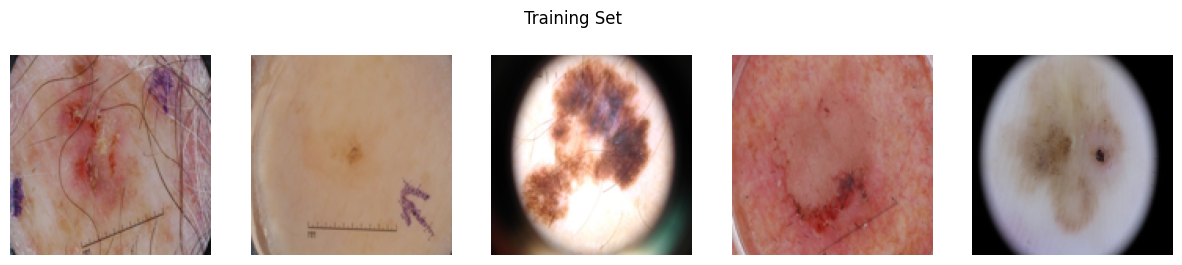

In [13]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, _, _) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
#plot_images(test_loader, "Test Set")

In [14]:
# create a custom convolutional neural network model for the classification task

import torchvision.models as models

model = models.resnet34(pretrained=True)
model.fc = torch.nn.Linear(512, 2)  # Change final layer for 2-class classification
model = model.to(device)
    
# create model
model.load_state_dict(torch.load('./customCNN_new_skincancer_binary.pth'))
model.to(device)

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_102104/1372197089.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# test model with a random input
x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[0.6270, 0.5047]], device='cuda:0', grad_fn=<AddmmBackward0>)


---

In [16]:
interpretabilities_dict = {}
interpretabilities_dict['ig'] = []
interpretabilities_dict['saliency'] = []
#interpretabilities_dict['deep_lift'] = []
#interpretabilities_dict['grad_cam'] = []
interpretabilities_dict['label_predicted'] = []
interpretabilities_dict['label_ground_truth'] = []

In [17]:
#layers = [
#    model.conv1,model.relu1,model.pool1,
#    model.conv2,model.relu2,model.pool2,
#    model.conv3,model.relu3,model.conv4,
#    model.relu4,model.conv5,model.relu5,
#    model.pool3,model.flatten,model.fc1,
#    model.relu6,model.fc2,model.relu7,
#    model.fc3,model.sigmoid
#    ]

In [18]:
model.eval()
ig = IntegratedGradients(model)
saliency = Saliency(model)
dl = DeepLift(model)
#cam = GradCAM(model, target_layers= [model.conv1, model.conv2, model.conv3])
#i = 0
for images, ground_truth, _ in test_loader:
    image = images.to(device)
    output = model(image)
    # get the argmax of the predicted class
    label_predicted = output.squeeze().argmax().item()
    interpretabilities_dict['label_predicted'].append(label_predicted)
    # get the argmax of the ground truth
    target = ground_truth.squeeze().argmax().item()
    interpretabilities_dict['label_ground_truth'].append(target)
    # Integrated Gradients
    attr_ig, delta_ig = ig.attribute(image, target=target, return_convergence_delta=True, n_steps=300)
    attr_ig = attr_ig.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_ig = np.transpose(attr_ig, (1, 0, 2))
    attr_ig_sum_norm = np.sum(np.abs(attr_ig), axis=2)
    attr_ig_sum_norm = attr_ig_sum_norm / np.max(attr_ig_sum_norm)
    interpretabilities_dict['ig'].append(attr_ig_sum_norm)
    # Saliency
    attr_saliency = saliency.attribute(image, target=target)
    attr_saliency = attr_saliency.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_saliency = np.transpose(attr_saliency, (1, 0, 2))
    attr_saliency_sum_norm = np.sum(np.abs(attr_saliency), axis=2)
    attr_saliency_sum_norm = attr_saliency_sum_norm / np.max(attr_saliency_sum_norm)
    interpretabilities_dict['saliency'].append(attr_saliency_sum_norm)
    ## DeepLift
    #attr_dl = dl.attribute(image, target=target)
    #attr_dl = attr_dl.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    #attr_dl = np.transpose(attr_dl, (1, 0, 2))
    #attr_dl_sum_norm = np.sum(np.abs(attr_dl), axis=2)
    #attr_dl_sum_norm = attr_dl_sum_norm / np.max(attr_dl_sum_norm)
    #interpretabilities_dict['deep_lift'].append(attr_dl_sum_norm)
    ## Grad cam
    #grayscale_cam = cam(input_tensor=image)
    #grayscale_cam = grayscale_cam[0, :]
    #interpretabilities_dict['grad_cam'].append(grayscale_cam)
    #i += 1
    #if i == 10:
    #    break

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [21]:
interpretabilities_dict['ig'][0].shape

(128, 128)

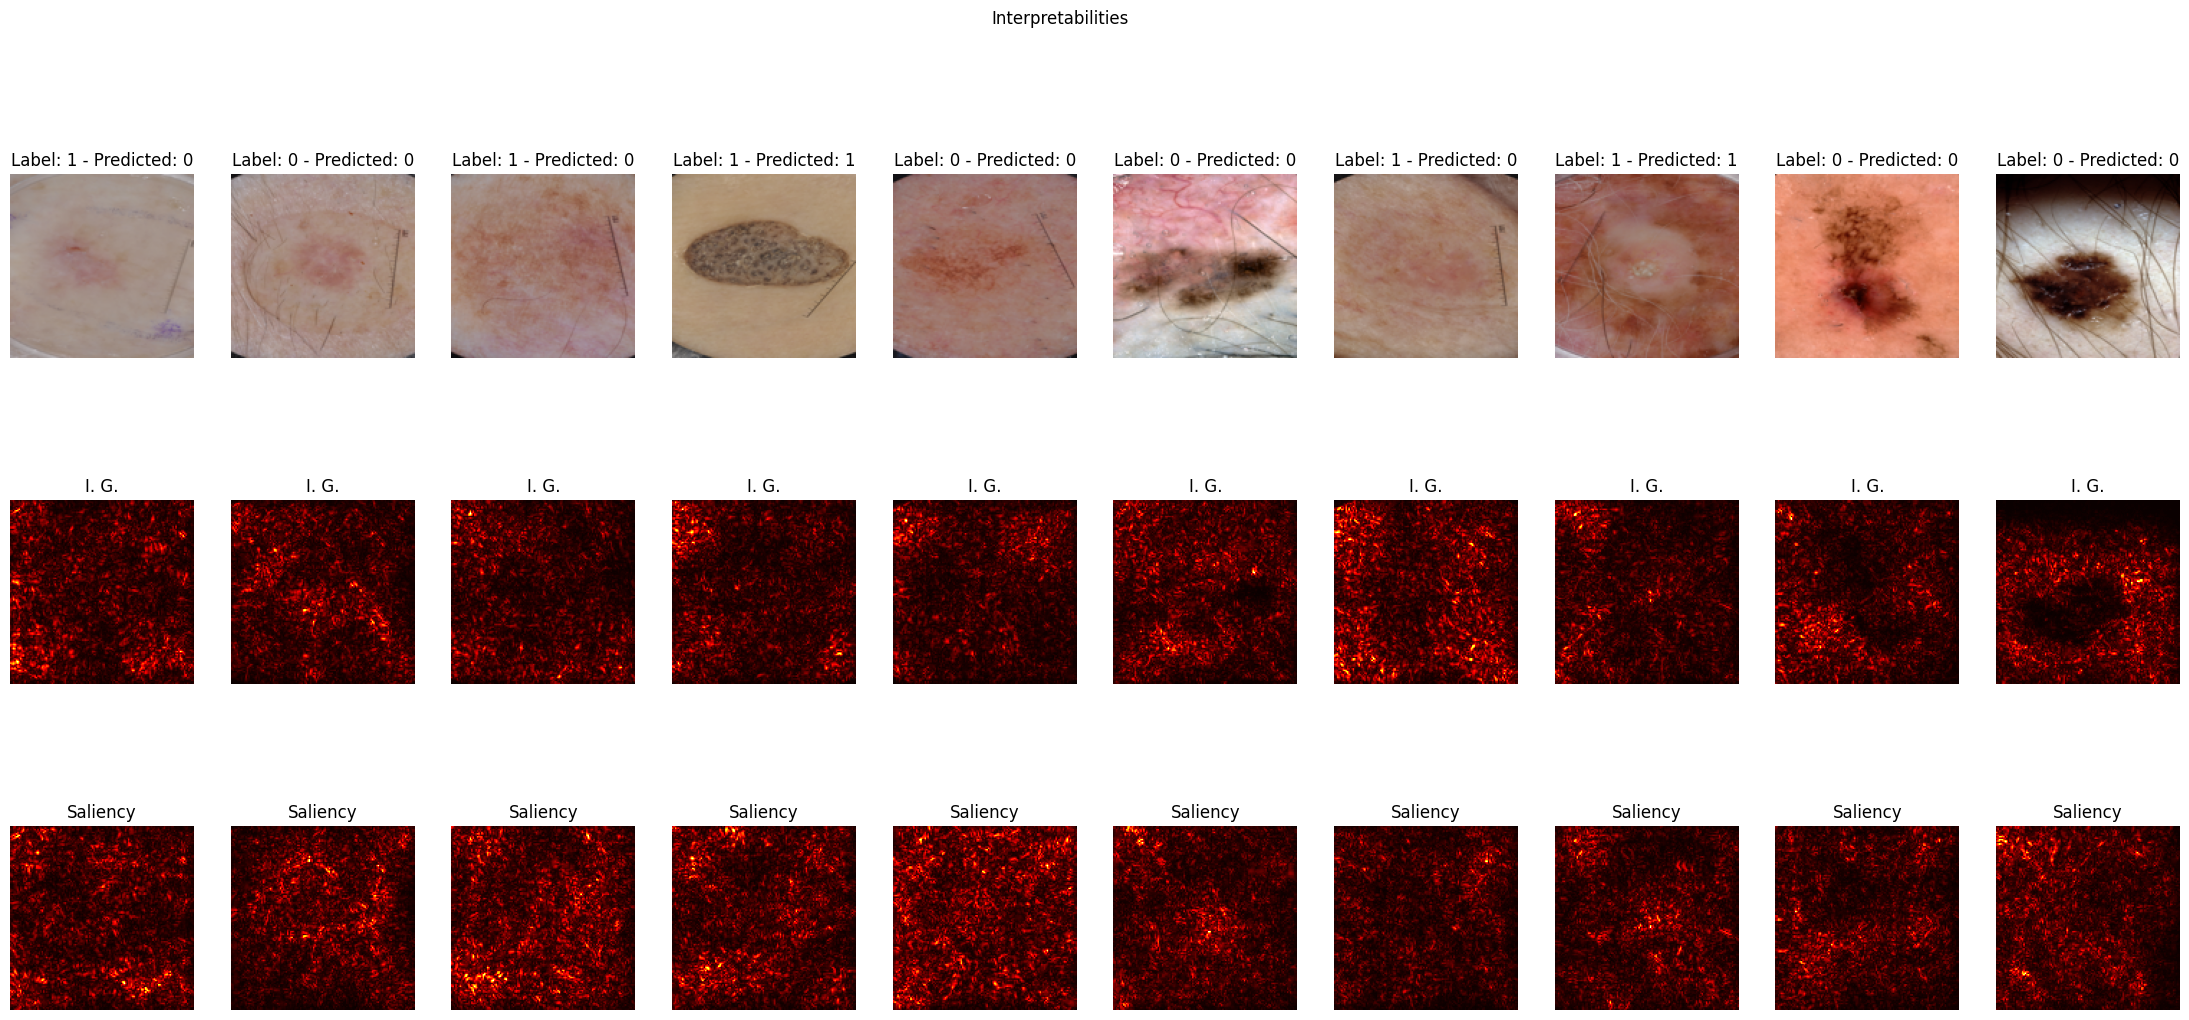

In [22]:
fig, axs = plt.subplots(3, 10, figsize=(28, 12))
i = 0
for images, ground_truth, _ in test_loader:
    target = ground_truth.squeeze().argmax().item()
    axs[0,i].imshow(images[0].squeeze().permute(2, 1, 0))
    axs[0,i].set_title(f"Label: {target} - Predicted: {interpretabilities_dict['label_predicted'][i]}")
    axs[0,i].axis("off")
    axs[1,i].imshow(interpretabilities_dict['ig'][i], cmap="hot")
    axs[1,i].set_title("I. G.")
    axs[1,i].axis("off")
    axs[2,i].imshow(interpretabilities_dict['saliency'][i], cmap="hot")
    axs[2,i].set_title("Saliency")
    axs[2,i].axis("off")
    #axs[3,i].imshow(interpretabilities_dict['deep_lift'][i], cmap="hot")
    #axs[3,i].set_title("DeepLift")
    #axs[3,i].axis("off")
    #axs[4,i].imshow(interpretabilities_dict['grad_cam'][i].T, cmap="hot")
    #axs[4,i].set_title("GradCAM")
    #axs[4,i].axis("off")
    i += 1
    if i == 10:
        break
fig.suptitle("Interpretabilities")
plt.show()

In [23]:
# function to calculate dice score given two numpy masks
def dice_score(mask1, mask2):
    mask1 = np.asarray(mask1).astype(bool)
    mask2 = np.asarray(mask2).astype(bool)
    intersection = np.sum(mask1 & mask2)
    dice = 2 * intersection / (np.sum(mask1) + np.sum(mask2))
    return dice

# function to calculate the IoU score given two numpy masks
def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return intersection.sum() / union.sum()

In [24]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [25]:
sam2_segmentations_dict = {}
sam2_segmentations_dict['ig'] = []
sam2_segmentations_dict['best_box_ig'] = []
sam2_segmentations_dict['saliency'] = []
sam2_segmentations_dict['best_box_saliency'] = []
#sam2_segmentations_dict['deep_lift'] = []
#sam2_segmentations_dict['best_box_deep_lift'] = []
#sam2_segmentations_dict['grad_cam'] = []
#sam2_segmentations_dict['best_box_grad_cam'] = []
sam2_segmentations_dict['dice_score_ig'] = []
sam2_segmentations_dict['iou_score_ig'] = []
sam2_segmentations_dict['dice_score_saliency'] = []
sam2_segmentations_dict['iou_score_saliency'] = []
#sam2_segmentations_dict['dice_score_deep_lift'] = []
#sam2_segmentations_dict['iou_score_deep_lift'] = []
#sam2_segmentations_dict['dice_score_grad_cam'] = []
#sam2_segmentations_dict['iou_score_grad_cam'] = []

In [26]:
def dual_annealing_best_box(image, invert = False):
    if invert:
        image = 1 - image
    def loss_function(params):
        x_ld, y_ld, x_ru, y_ru = params
        x1, y1, x2, y2 = int(x_ld), int(y_ld), int(x_ru), int(y_ru)
        
        # Ensure valid box dimensions
        if x1 >= x2 or y1 >= y2:
            return 1e6  # Penalize invalid rectangles
        
        image_cropped = image[y1:y2, x1:x2]
        image_cropped = image_cropped**2
        image_cropped_sum = np.sum(image_cropped)
        sum_image = np.sum(image)
        average_pixel_value = image_cropped_sum / (image_cropped.shape[0] * image_cropped.shape[1])
        box_area = (x2 - x1) * (y2 - y1)

        if box_area == 0:
            return 1e6  # Avoid division by zero

        return -(average_pixel_value**0.5 * np.log(box_area) * sum_image**0.5)  # negative for minimization
    # -(average_pixel_value**0.5 * np.log(box_area) * sum_image**0.5)

    # Define bounds ensuring x_ld < x_ru and y_ld < y_ru
    h, w = image.shape
    bounds = [(10, w - 1), (10, h - 1), (20, w), (20, h)]

    # Perform optimization
    result = scipy.optimize.dual_annealing(loss_function, bounds=bounds, maxiter=100)
    return result

In [27]:
i = 0
n_mask_sam = 0
for images, ground_truth, mask_ground_truth in test_loader:
    predictor.set_image(np.array(images[0].permute(1, 2, 0)))
    
    # Integrated Gradients
    attr_ig = interpretabilities_dict['ig'][i]
    res_dual_annealing = dual_annealing_best_box(attr_ig, invert=False)
    x1, y1, x2, y2 = res_dual_annealing.x
    if x1 - 10 >= 0:
        x1 -= 10
    if x2 + 10 <= 128:
        x2 += 10
    if y1 - 10 >= 0:
        y1 -= 10
    if y2 + 10 <= 128:
        y2 += 10
    box_input = [x1, y1, x2, y2]
    sam2_segmentations_dict['best_box_ig'].append(box_input)
    masks, scores, _ = predictor.predict(box = box_input, multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    mask = masks[n_mask_sam]
    sam2_segmentations_dict['ig'].append(mask)
    # calculate dice and iou scores
    dice = dice_score(np.array(mask_ground_truth), mask)
    iou = iou_score(np.array(mask_ground_truth), mask)
    sam2_segmentations_dict['dice_score_ig'].append(dice)
    sam2_segmentations_dict['iou_score_ig'].append(iou)

    # Saliency
    attr_saliency = interpretabilities_dict['saliency'][i]
    res_dual_annealing = dual_annealing_best_box(attr_ig, invert=False)
    x1, y1, x2, y2 = res_dual_annealing.x
    if x1 - 10 >= 0:
        x1 -= 10
    if x2 + 10 <= 128:
        x2 += 10
    if y1 - 10 >= 0:
        y1 -= 10
    if y2 + 10 <= 128:
        y2 += 10
    box_input = [x1, y1, x2, y2]
    sam2_segmentations_dict['best_box_saliency'].append(box_input)
    masks, scores, _ = predictor.predict(box = box_input, multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    mask = masks[n_mask_sam]
    sam2_segmentations_dict['saliency'].append(mask)
    # calculate dice and iou scores
    dice = dice_score(np.array(mask_ground_truth), mask)
    iou = iou_score(np.array(mask_ground_truth), mask)
    sam2_segmentations_dict['dice_score_saliency'].append(dice)
    sam2_segmentations_dict['iou_score_saliency'].append(iou)

    ## DeepLift
    #attr_deep_lift = interpretabilities_dict['deep_lift'][i]
    #res_dual_annealing = dual_annealing_best_box(attr_ig, invert=False)
    #x1, y1, x2, y2 = res_dual_annealing.x
    #if x1 - 10 >= 0:
    #    x1 -= 10
    #if x2 + 10 <= 128:
    #    x2 += 10
    #if y1 - 10 >= 0:
    #    y1 -= 10
    #if y2 + 10 <= 128:
    #    y2 += 10
    #box_input = [x1, y1, x2, y2]
    #sam2_segmentations_dict['best_box_deep_lift'].append(box_input)
    #masks, scores, _ = predictor.predict(box = box_input, multimask_output=True) #predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
    #sorted_ind = np.argsort(scores)[::-1]
    #masks = masks[sorted_ind]
    #mask = masks[n_mask_sam]
    #sam2_segmentations_dict['deep_lift'].append(mask)
    ## calculate dice and iou scores
    #dice = dice_score(np.array(mask_ground_truth), mask)
    #iou = iou_score(np.array(mask_ground_truth), mask)
    #sam2_segmentations_dict['dice_score_deep_lift'].append(dice)
    #sam2_segmentations_dict['iou_score_deep_lift'].append(iou)

    ## Grad Cam
    #attr_grad_cam = interpretabilities_dict['grad_cam'][i]
    #res_dual_annealing = dual_annealing_best_box(attr_ig, invert=False)
    #x1, y1, x2, y2 = res_dual_annealing.x
    #if x1 - 10 >= 0:
    #    x1 -= 10
    #if x2 + 10 <= 128:
    #    x2 += 10
    #if y1 - 10 >= 0:
    #    y1 -= 10
    #if y2 + 10 <= 128:
    #    y2 += 10
    #box_input = [x1, y1, x2, y2]
    #sam2_segmentations_dict['best_box_grad_cam'].append(box_input)
    #masks, scores, _ = predictor.predict(box = box_input, multimask_output=True)
    #sorted_ind = np.argsort(scores)[::-1]
    #masks = masks[sorted_ind]
    #mask = masks[n_mask_sam]
    #sam2_segmentations_dict['grad_cam'].append(mask)
    ## calculate dice and iou scores
    #dice = dice_score(np.array(mask_ground_truth), mask)
    #iou = iou_score(np.array(mask_ground_truth), mask)
    #sam2_segmentations_dict['dice_score_grad_cam'].append(dice)
    #sam2_segmentations_dict['iou_score_grad_cam'].append(iou)

    i += 1
    
    ## rapid test
    #if i == 20:
    #    break

In [28]:
df_results = pd.DataFrame(sam2_segmentations_dict, index=test_ids)
df_results = df_results[df_results.columns[8:]]
df_results['label_ground_truth'] = interpretabilities_dict['label_ground_truth']
df_results["label_predicted"] = interpretabilities_dict['label_predicted']
df_results

,label_ground_truth,label_predicted
ISIC_0012266,1,0
ISIC_0014186,0,0
ISIC_0012510,1,0
ISIC_0012272,1,1
ISIC_0014336,0,0
...,...,...
ISIC_0013617,0,0
ISIC_0012395,0,0
ISIC_0014800,0,0
ISIC_0015142,0,0


In [29]:
df_results.describe()

,label_ground_truth,label_predicted
count,207.000000,207.000000
mean,0.434783,0.265700
std,0.496930,0.442776
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [30]:
df_results[df_results['label_ground_truth'] == df_results['label_predicted']].describe()

,label_ground_truth,label_predicted
count,146.000000,146.000000
mean,0.287671,0.287671
std,0.454235,0.454235
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [31]:
df_results.to_csv('df_results_skincancer_new_interpretability_with_optimized_boxes_binary_classes.csv')

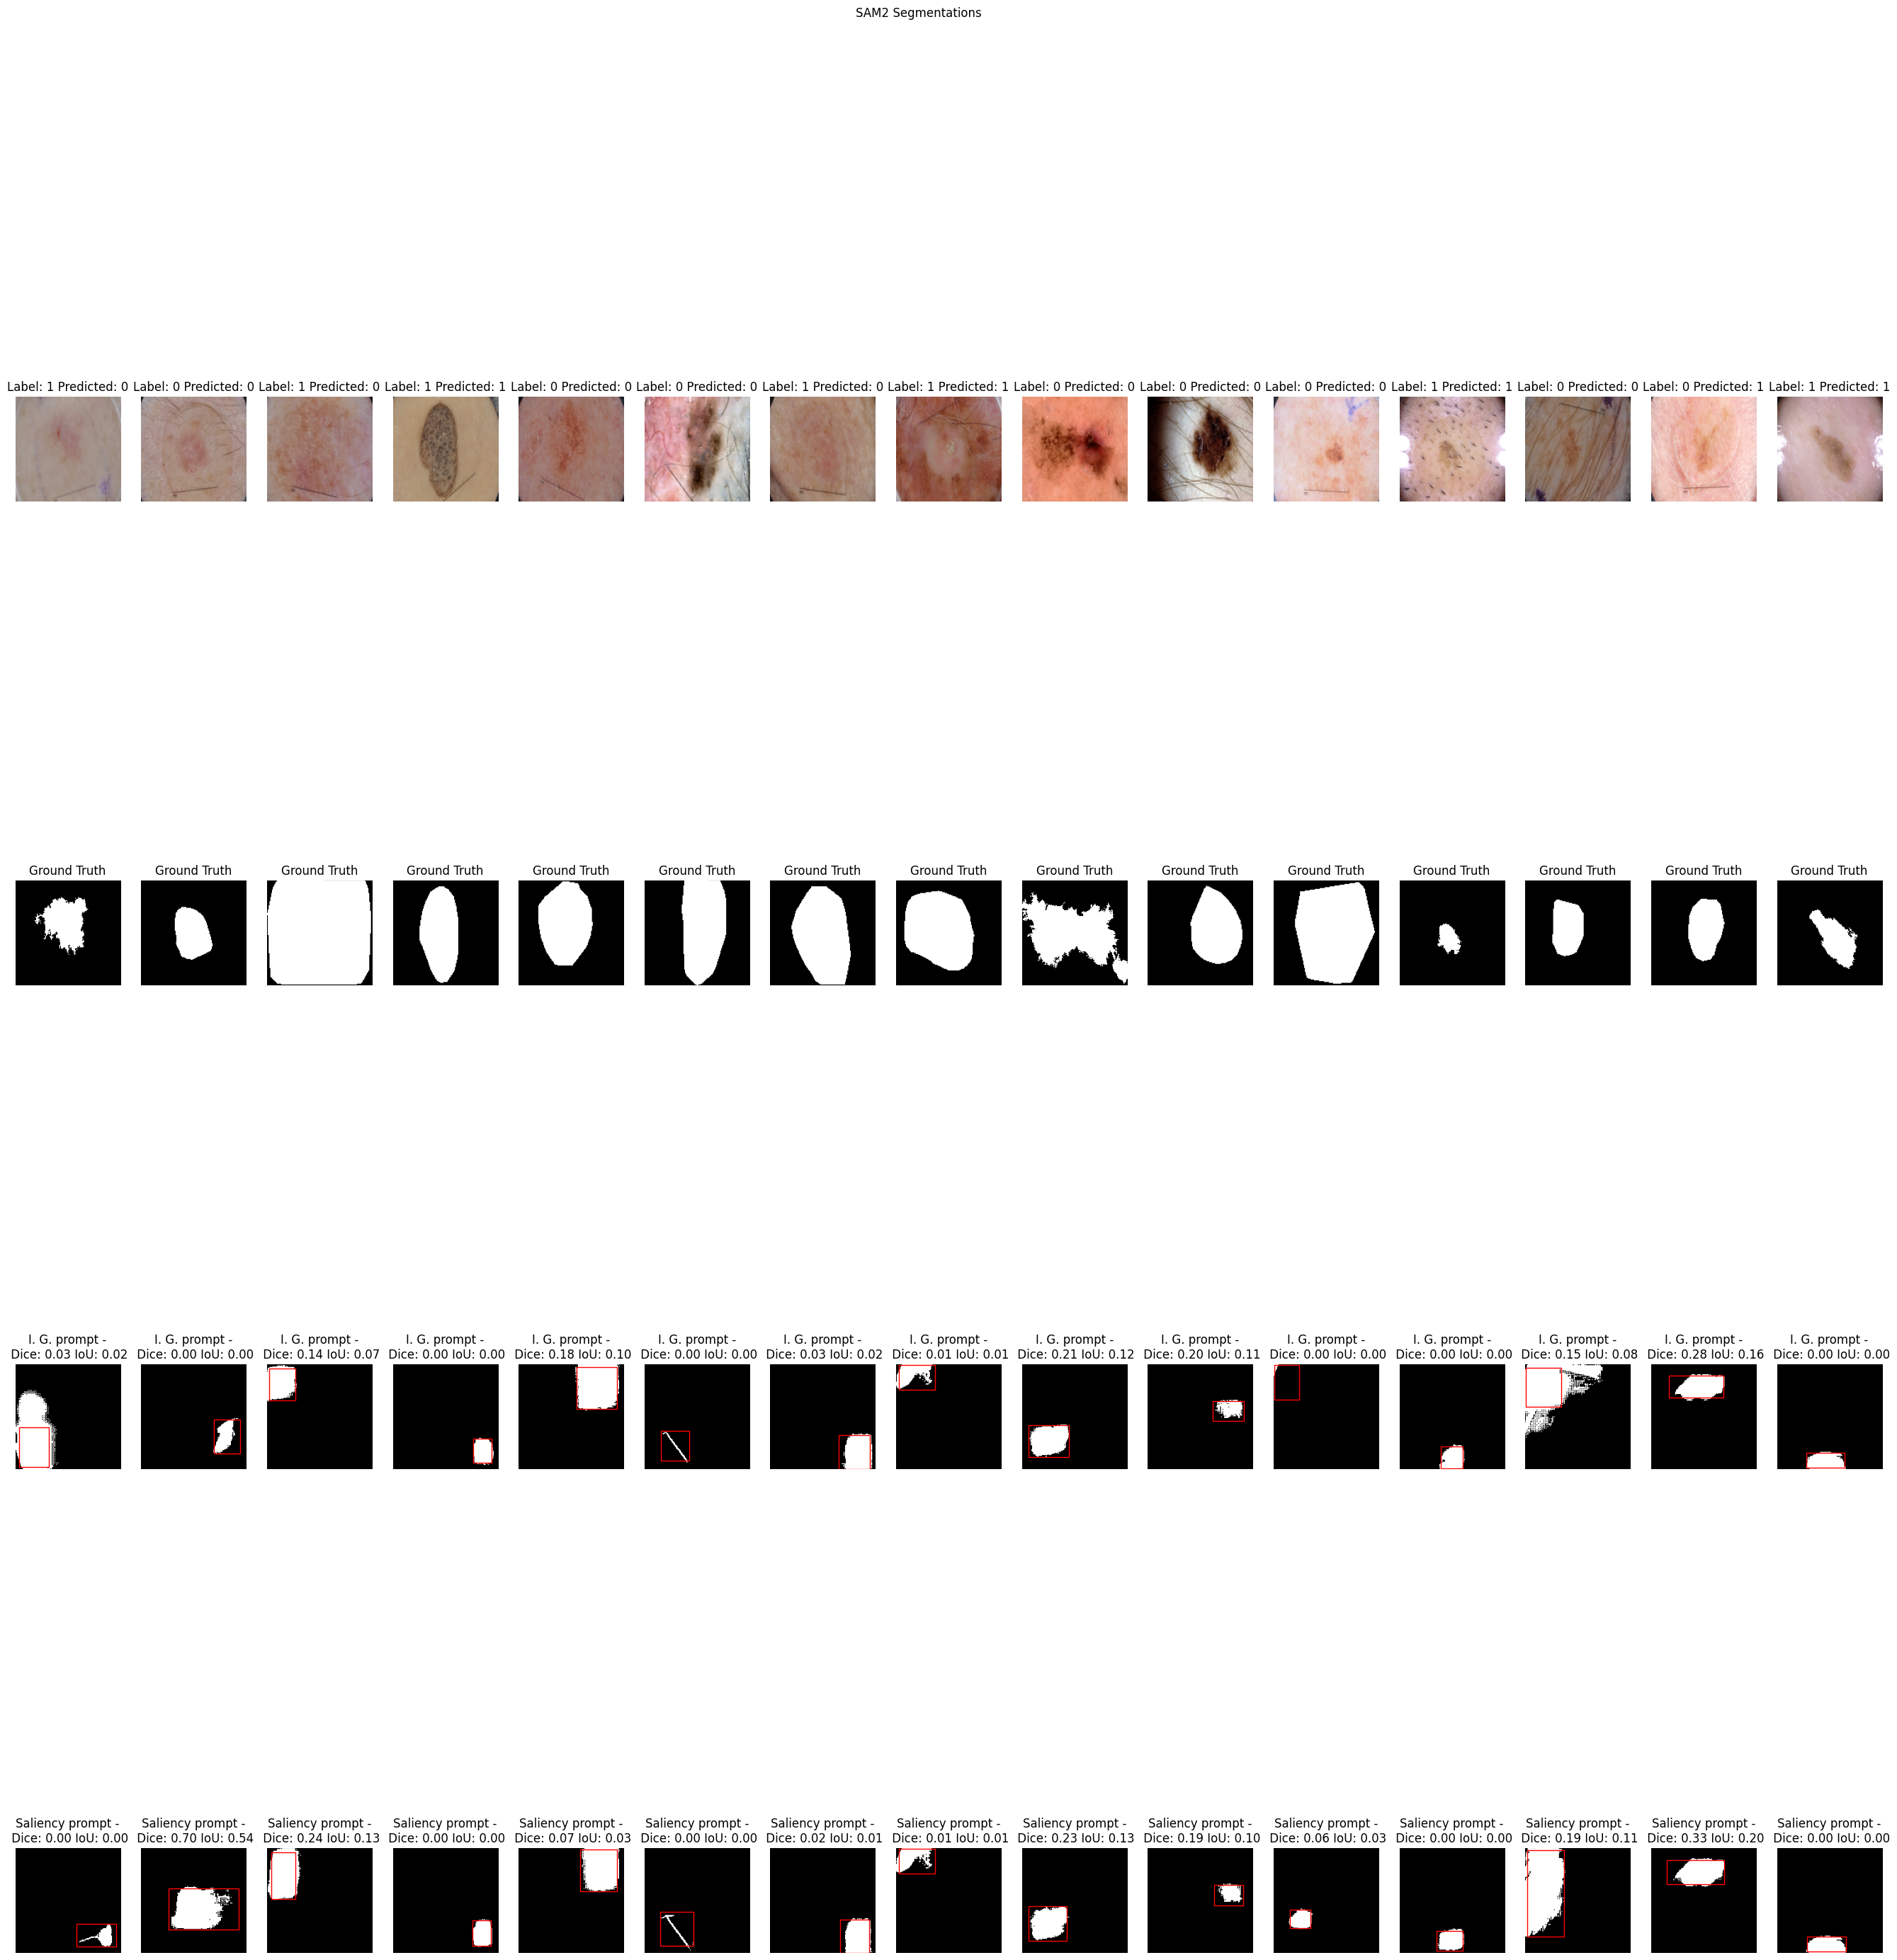

In [32]:
fig, axs = plt.subplots(4, 15, figsize=(34, 34))
offset = 0
i = 0 + offset
for images, ground_truth, mask_ground_truth in test_loader:
    axs[0,i-offset].imshow(np.array(images[0].permute(1, 2, 0)))
    axs[0,i-offset].set_title(f"Label: {ground_truth.squeeze().argmax().item()} Predicted: {interpretabilities_dict['label_predicted'][i]}")
    axs[0,i-offset].axis("off")
    # show the ground truth mask
    axs[1,i-offset].imshow(np.array(mask_ground_truth.squeeze()), cmap="gray")
    axs[1,i-offset].set_title("Ground Truth")
    axs[1,i-offset].axis("off")

    axs[1+1,i-offset].imshow(sam2_segmentations_dict['ig'][i].squeeze(), cmap="gray")
    axs[1+1,i-offset].set_title("I. G. prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_ig'][i], sam2_segmentations_dict['iou_score_ig'][i]))
    box = sam2_segmentations_dict['best_box_ig'][i]
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
    axs[1+1,i-offset].add_patch(rect)
    axs[1+1,i-offset].axis("off")

    axs[2+1,i-offset].imshow(sam2_segmentations_dict['saliency'][i].squeeze(), cmap="gray")
    axs[2+1,i-offset].set_title("Saliency prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_saliency'][i], sam2_segmentations_dict['iou_score_saliency'][i]))
    box = sam2_segmentations_dict['best_box_saliency'][i]
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
    axs[2+1,i-offset].add_patch(rect)
    axs[2+1,i-offset].axis("off")

    #axs[3+1,i-offset].imshow(sam2_segmentations_dict['deep_lift'][i].squeeze(), cmap="gray")
    #axs[3+1,i-offset].set_title("DeepLift prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_deep_lift'][i], sam2_segmentations_dict['iou_score_deep_lift'][i]))
    #box = sam2_segmentations_dict['best_box_deep_lift'][i]
    #x1, y1, x2, y2 = box
    #rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
    #axs[3+1,i-offset].add_patch(rect)
    #axs[3+1,i-offset].axis("off")

    #axs[4+1,i-offset].imshow(sam2_segmentations_dict['grad_cam'][i].squeeze(), cmap="gray")
    #axs[4+1,i-offset].set_title("GradCAM prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_grad_cam'][i], sam2_segmentations_dict['iou_score_grad_cam'][i]))
    #box = sam2_segmentations_dict['best_box_grad_cam'][i]
    #x1, y1, x2, y2 = box
    #rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
    #axs[4+1,i-offset].add_patch(rect)
    #axs[4+1,i-offset].axis("off")
    
    i = i + 1
    if i == 15 + offset:
        break
fig.suptitle("SAM2 Segmentations")
plt.show()

In [33]:
###DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    #print(elem[1]['pca'][0][0])
#    plt.imshow(1 - elem[1]['pca'][0][0], cmap='gray')
#    plt.show()
#    if i == 0:
#        break

In [34]:
#image_name = 'ISIC_0016028'
#image_name = 'ISIC_0015185'

In [35]:
#res_dual_annealing = dual_annealing_best_box(image = images_dict[image_name]['pca'][0][0])
#print(res_dual_annealing)
## plot the pca_np image and the best box for the first image
#fig, ax = plt.subplots(1, 3, figsize=(9, 11))
#ax[0].imshow(images_dict[image_name]['pca'][0][0], cmap='gist_rainbow')
#ax[0].axis('off')
#ax[0].set_title(image_name)
#x1, y1, x2, y2 = res_dual_annealing.x
#ax[1].imshow(1 - images_dict[image_name]['pca'][0][0], cmap='gray')
#ax[1].axis('off')
#ax[1].set_title(f'{image_name} PC1 with best box')
#rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
#ax[1].add_patch(rect)
## add original image
#ax[2].imshow(images_dict[image_name]['image'])
#ax[2].axis('off')
#ax[2].set_title(f'{image_name} Original')
#rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
#ax[2].add_patch(rect)
#plt.show()

In [36]:
##DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem)
#    if i == 0:
#        break

NameError: name 'images_dict' is not defined

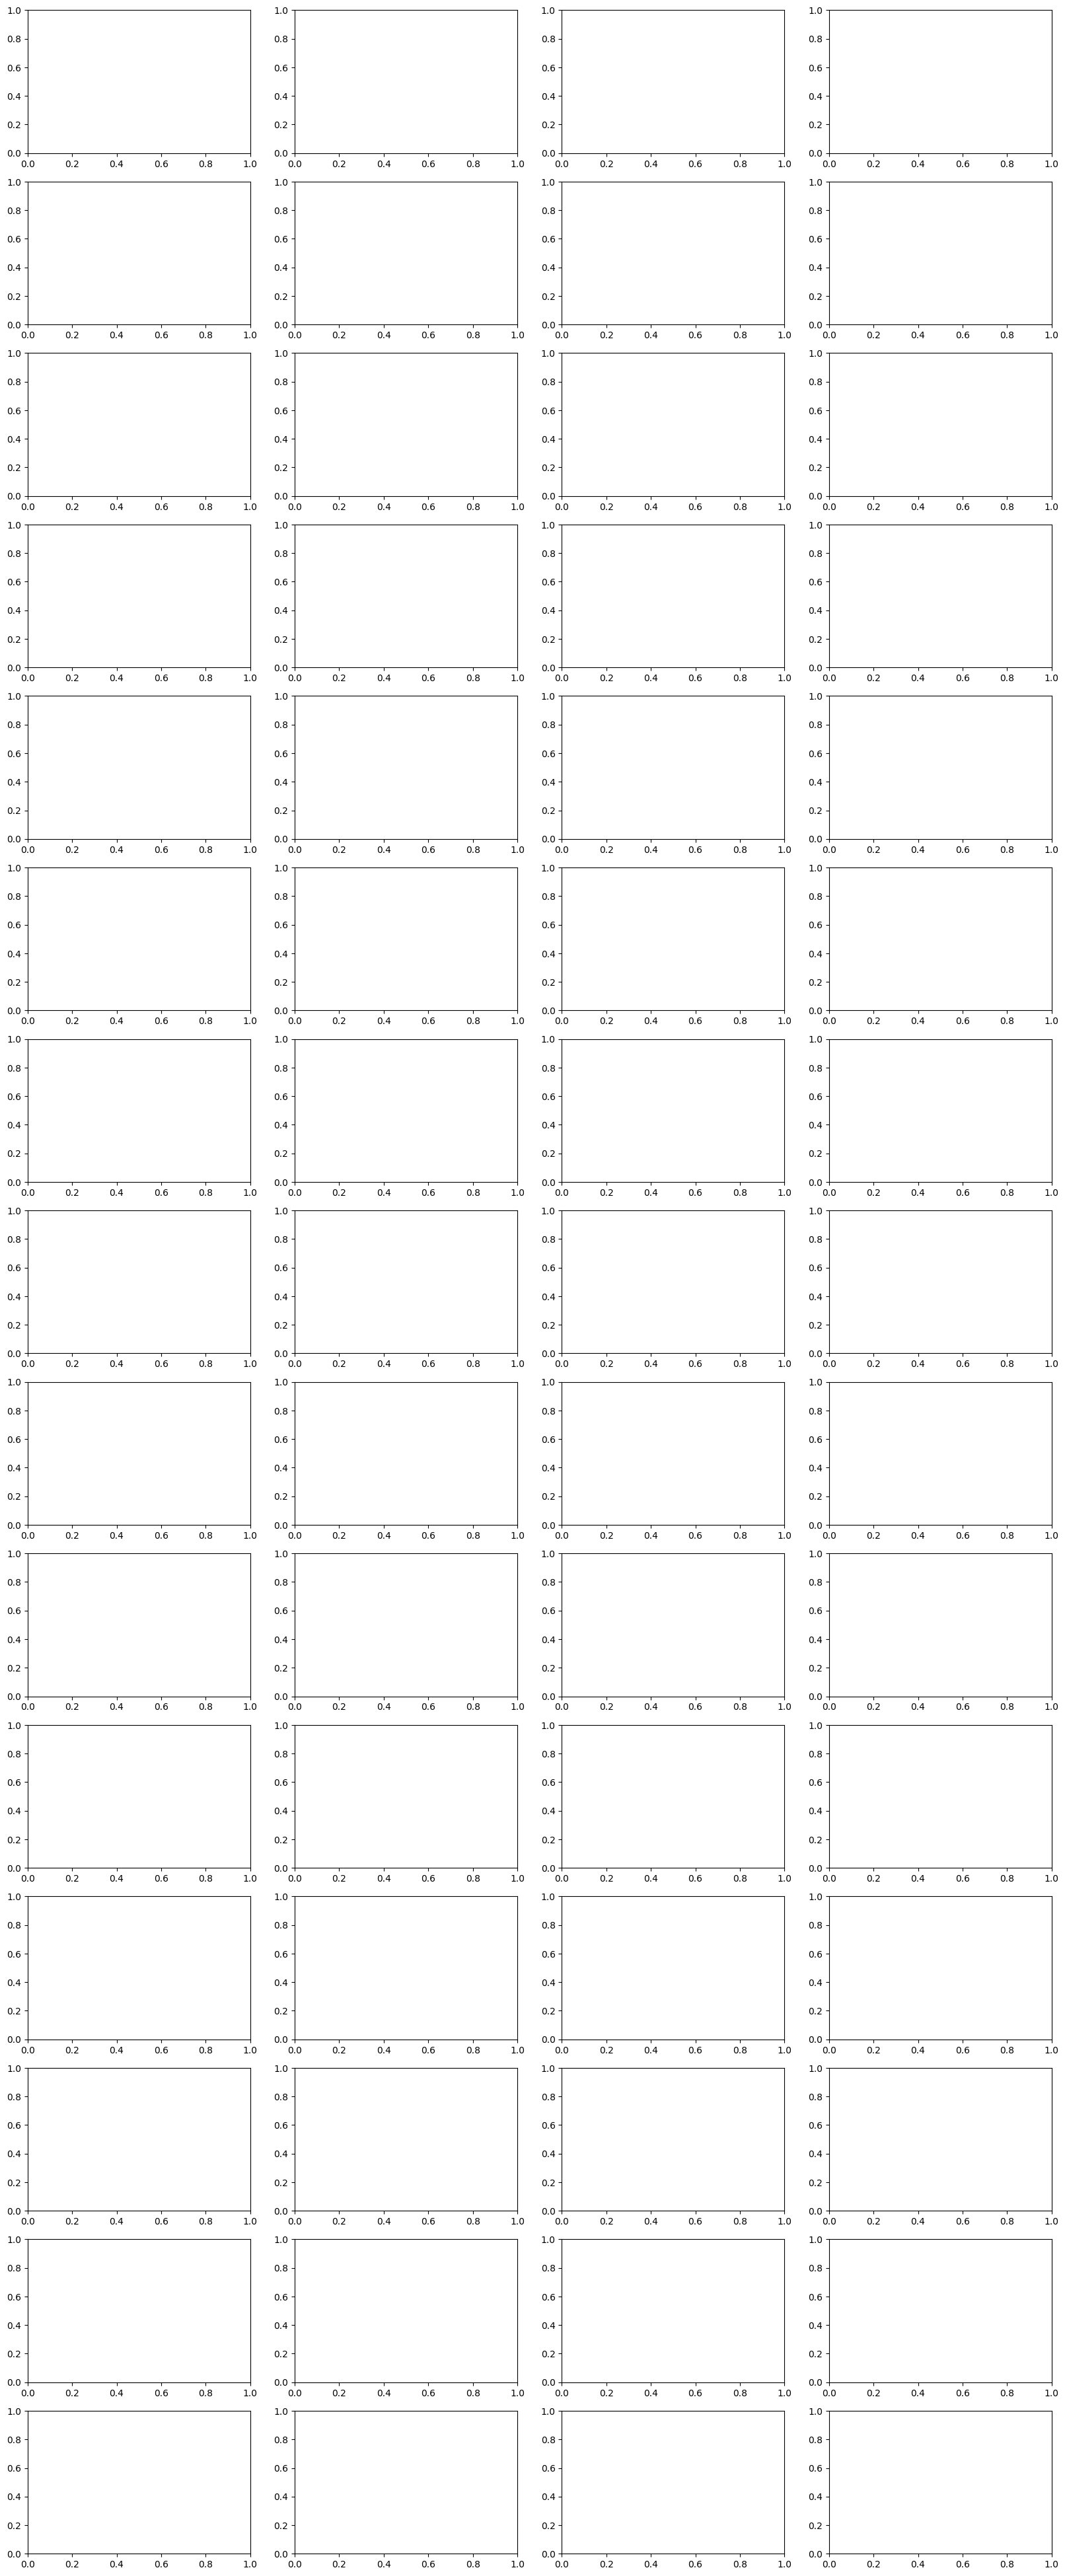

In [37]:
# plot for the first 15 images the mask for each pca component (input)
fig, ax = plt.subplots(15, 4, figsize=(20, 50))
for i, item in enumerate(images_dict.items()):
    if i == 15:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    ax[i, 1].imshow(item[1]['mask'], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title('Ground Truth')
    # plot pca1 + box
    pca_1_matrix = 1 - item[1]['pca'][0][0]
    ax[i, 2].imshow(pca_1_matrix, cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].set_title('PCA 1 + optimized box')
    box = item[1]['optimized_box'][0]
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
    ax[i, 2].add_patch(rect)
    predicted = item[1]['predicted_masks_pca'][0]
    ax[i, 3].imshow(predicted, cmap='gray')
    ax[i, 3].axis('off')
    ax[i, 3].set_title(f'predicted \n (dice {item[1]['dice_scores_predicted_masks_pca'][0]:.2f}) (IoU {item[1]['iou_scores_predicted_masks_pca'][0]:.2f})')
    
